In [44]:
import json

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

import numpy as np

import openturns as ot
import openturns.viewer as viewer
import openturns.viewer as otv

plt.rcParams['figure.dpi']= 500

# Importing Data

In [45]:
# Color scheme for chemical conditioning
colors_ch = {'Morpholine': {'9.2': ['g', 0.05], '9.6': ['g', 0.2]},
             'ETA': {'9.2': ['b', 0.05], '9.6': ['b', 0.2]},
             'Ammoniaque' : {'9.2': ['r', 0.05], '9.7': ['r', 0.2]}}

In [46]:
# Parameters of the Steam Generator
input_dic = {}
input_dic['SG'] = json.load(open('data/data.json'))

In [47]:
# Input-Output of THYC-Puffer-DEPOTHYC in Hot Branch and Cold Branch
dataset_HL = ot.Sample.ImportFromCSVFile('data/DataSet_HL.csv')
dataset_CL = ot.Sample.ImportFromCSVFile('data/DataSet_CL.csv')

In [48]:
# Monte-Carlo sample of input variables for THYC-Puffer-DEPOTHYC
inputSample = dataset_HL[:,0:7]

In [49]:
# Clogging output as a function of time
outputSample_HL = dataset_HL[:,7:]
outputSample_CL = dataset_CL[:,7:]

In [50]:
# Time indices in days
t = [i*250 for i in range(75)]

## General $R^2_{HSIC}$

In [51]:
hsic_time_HL, hsic_time_CL = [], []
estimatorType_u = ot.HSICVStat() 
p_values_HL, p_values_CL = [], []

In [52]:
for i in range(75):
    
    tauSample_HL = outputSample_HL[:,i]
    tauSample_CL = outputSample_CL[:,i]

    covarianceModelCollection_HL, covarianceModelCollection_CL = [], []
    for i in range(7):
        Xi = inputSample.getMarginal(i)
        Cov = ot.SquaredExponential(1)
        Cov.setScale(Xi.computeStandardDeviation())
        covarianceModelCollection_HL.append(Cov)
        covarianceModelCollection_CL.append(Cov)

    covarianceModelCollection_HL.append(ot.SquaredExponential(tauSample_HL.computeStandardDeviation()))
    covarianceModelCollection_CL.append(ot.SquaredExponential(tauSample_CL.computeStandardDeviation()))

    hsic_u_HL = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection_HL, inputSample, tauSample_HL, estimatorType_u)
    hsic_u_CL = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection_CL, inputSample, tauSample_CL, estimatorType_u)
    
    r2_u_HL = hsic_u_HL.getR2HSICIndices()
    r2_u_CL = hsic_u_CL.getR2HSICIndices()

    hsic_time_HL.append(list(np.abs(r2_u_HL)))
    hsic_time_CL.append(list(np.abs(r2_u_CL)))
    
    _p_HL, _p_CL = [],[]
    
    for j in range(7):
        _p_HL.append(round(estimatorType_u.computePValue(ot.Gamma(), 969, hsic_u_HL.getHSICIndices()[j], 0.0),4))
        _p_CL.append(round(estimatorType_u.computePValue(ot.Gamma(), 969, hsic_u_CL.getHSICIndices()[j], 0.0),4))

    p_values_HL.append(_p_HL)
    p_values_CL.append(_p_CL)


In [53]:
hsic_time_HL = list(np.transpose(np.asarray(hsic_time_HL)))
hsic_time_CL = list(np.transpose(np.asarray(hsic_time_CL)))

p_values_HL = list(np.transpose(np.asarray(p_values_HL)))
p_values_CL = list(np.transpose(np.asarray(p_values_CL)))

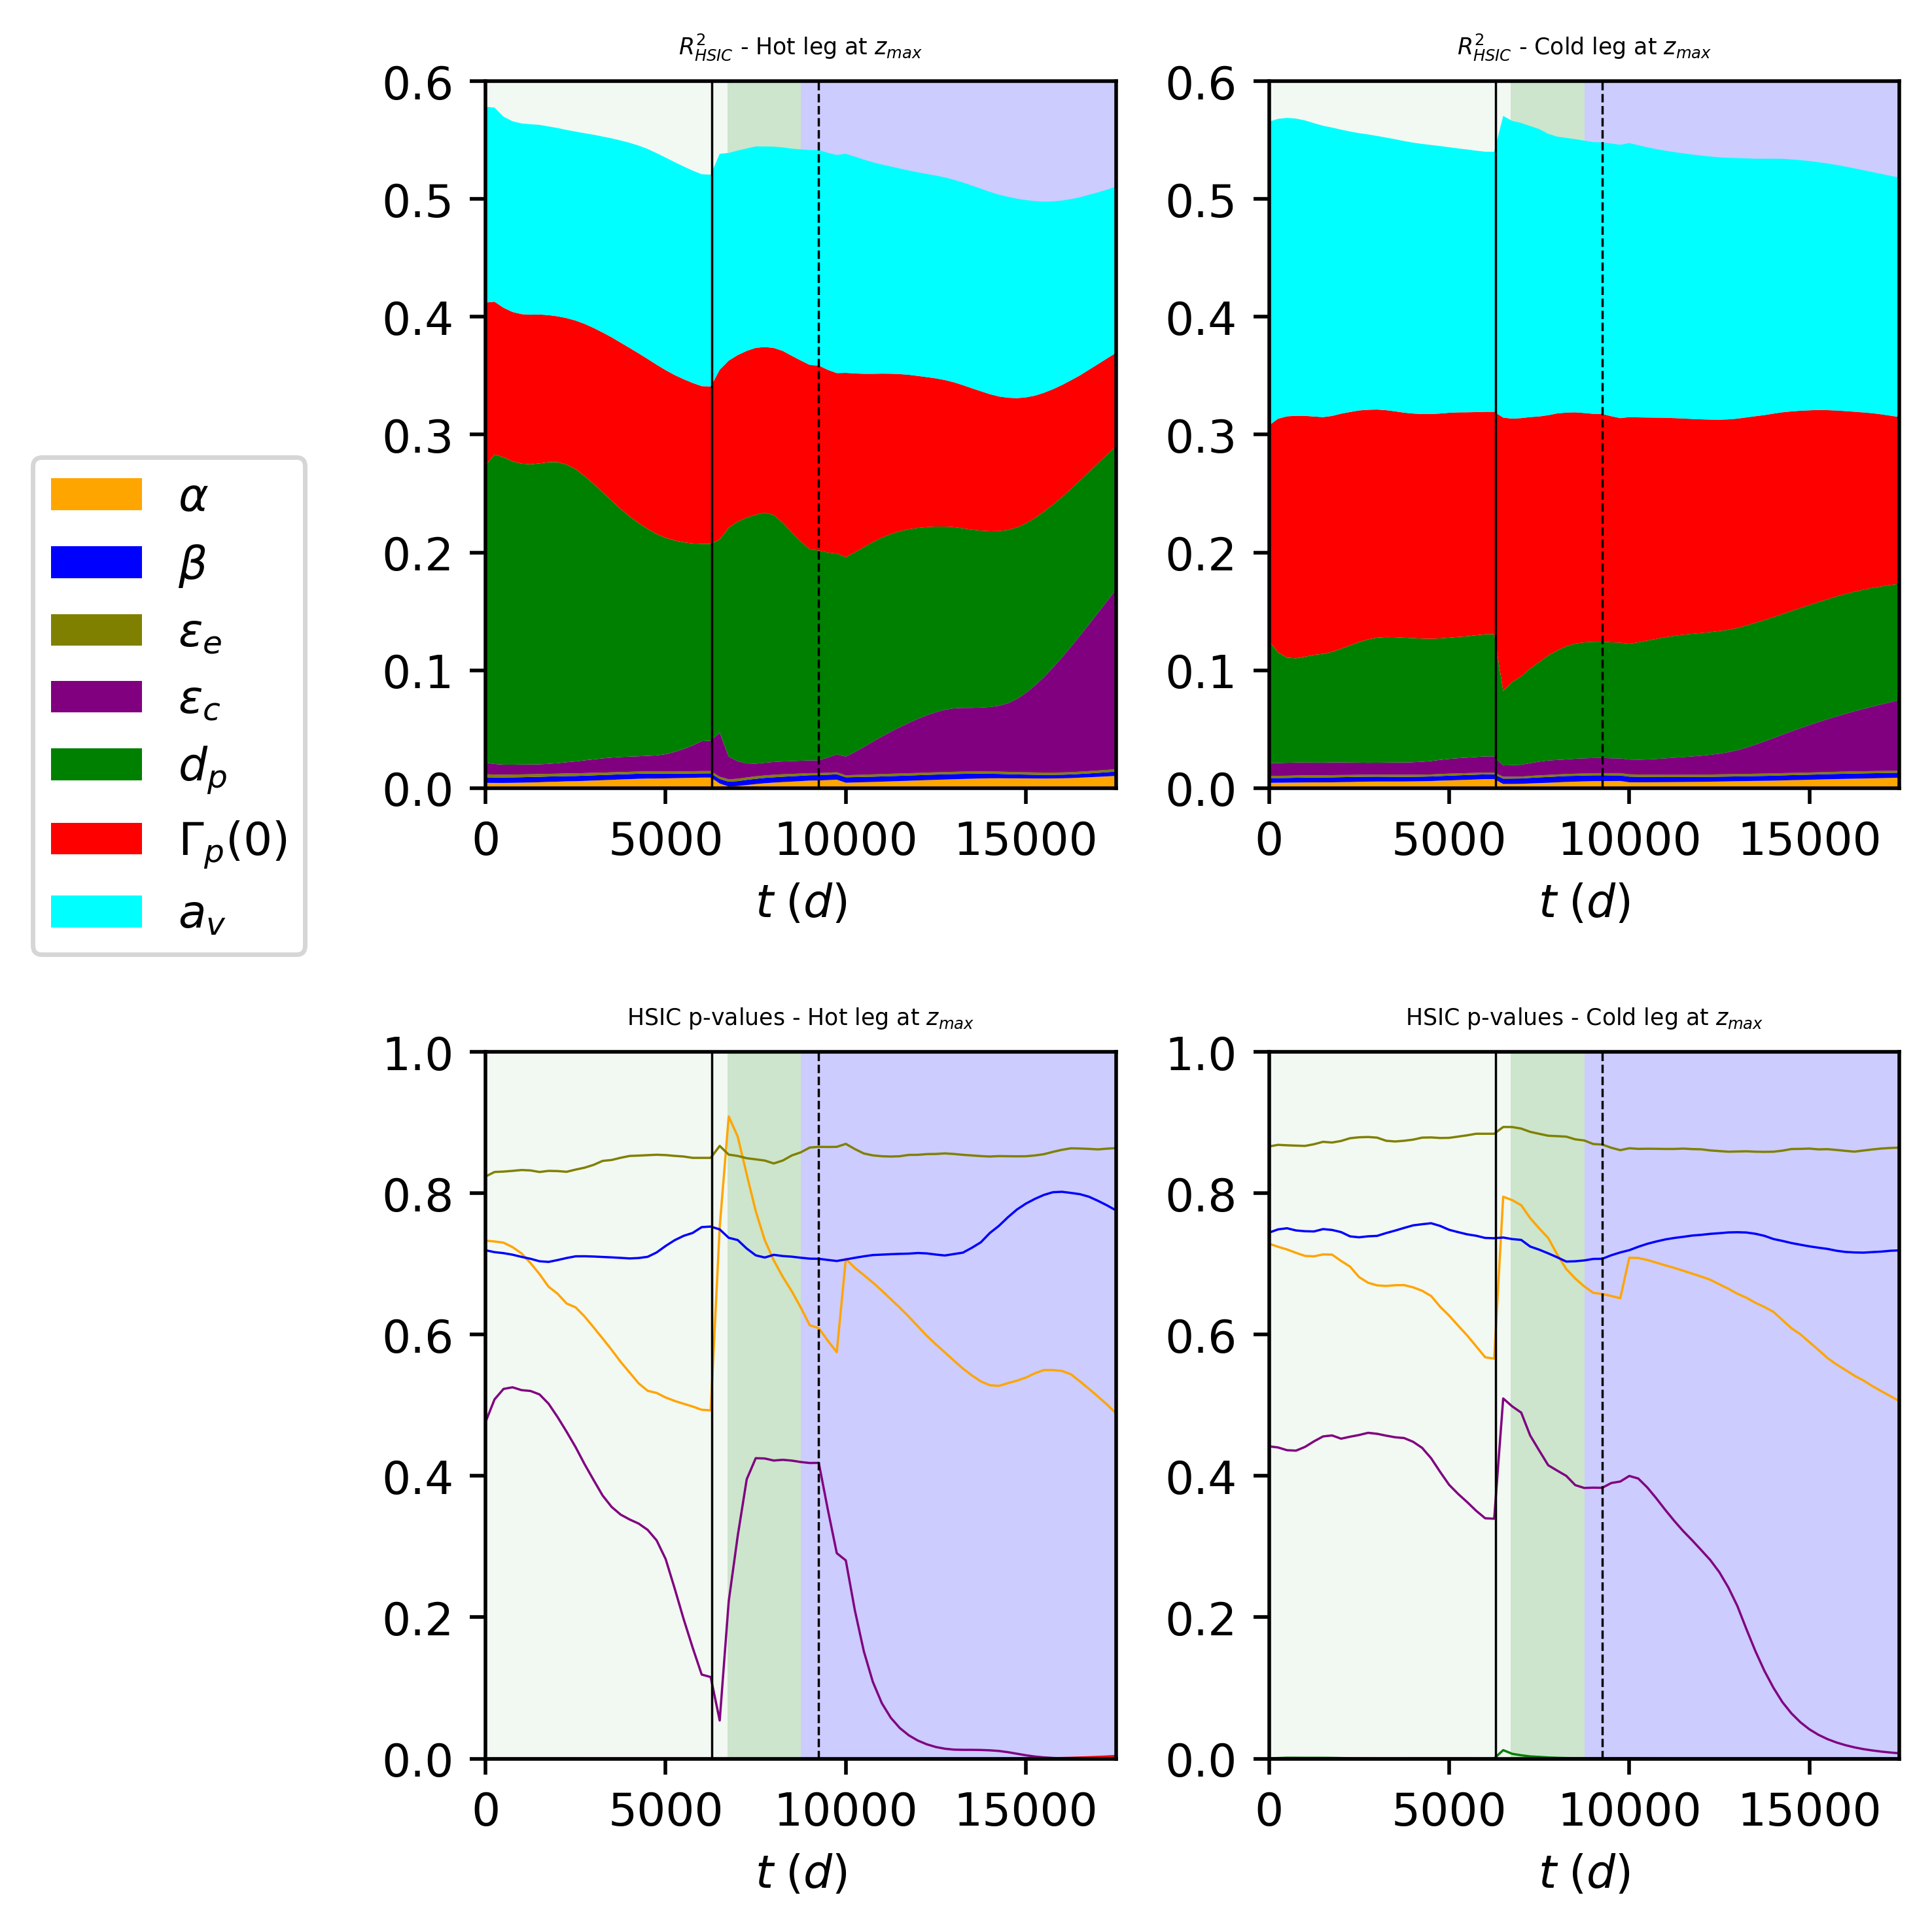

In [54]:
fig, axs = plt.subplots(2,2,figsize=(6,6),layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_ch[c['type']]
    col = typ[str(c['ph'])]
    axs[0,0].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[0,1].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[1,0].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[1,1].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])

axs[0,0].stackplot(t,hsic_time_HL, labels=labels, colors=colors)
axs[0,0].set_xlim(0,17500)
axs[0,0].set_ylim(0,0.6)
axs[0,0].set_xlabel(r'$t\;(d)$')
axs[0,0].set_title(r'$R^{2}_{HSIC}$ - Hot leg at $z_{max}$', fontsize=5)

axs[0,1].stackplot(t,hsic_time_CL, labels=labels, colors=colors)
axs[0,1].set_xlim(0,17500)
axs[0,1].set_ylim(0,0.6)
axs[0,1].set_xlabel(r'$t\;(d)$')
axs[0,1].set_title(r'$R^{2}_{HSIC}$ - Cold leg at $z_{max}$',  fontsize=5)

for k in range(7):
    axs[1,0].plot(t,p_values_HL[k], c=colors[k], linewidth=0.5)
    axs[1,0].set_xlim(0,17500)
    axs[1,0].set_ylim(0,1.0)
    axs[1,0].set_xlabel(r'$t\;(d)$')
    axs[1,0].set_title(r'HSIC p-values - Hot leg at $z_{max}$',  fontsize=5)

    axs[1,1].plot(t,p_values_CL[k], c=colors[k], linewidth=0.5)
    axs[1,1].set_xlim(0,17500)
    axs[1,1].set_ylim(0,1.0)
    axs[1,1].set_xlabel(r'$t\;(d)$')
    axs[1,1].set_title(r'HSIC p-values - Cold leg at $z_{max}$',  fontsize=5)

axs[0,0].legend(bbox_to_anchor=(-0.25,0.5))


nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs[0,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[0,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventif':
        axs[0,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[0,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)

#fig.savefig('plots/HSIC/R2_HSIC_tot.pdf', format='pdf')
#fig.savefig('plots/HSIC/R2_HSIC_tot.png', format='png')

## Target HSIC

In [ ]:
hsic_target_time_HL, hsic_target_time_CL = [], []
p_values_target_HL, p_values_target_CL = [], []
estimatorType_u = ot.HSICVStat() 

In [1]:
dist = ot.DistanceToDomainFunction(ot.Interval(99, float('inf')))
func = ot.SymbolicFunction('x', 'exp(-0.5 * x)')
filterFunction= ot.ComposedFunction(func, dist)

NameError: name 'ot' is not defined

In [ ]:
for i in range(75):

    tauSample_HL = outputSample_HL[:,i]
    tauSample_CL = outputSample_CL[:,i]
    
    #filterFunction = ot.IndicatorFunction(ot.Interval(30, float('inf')))
    
    covarianceModelCollection_HL, covarianceModelCollection_CL = [], []
    
    for i in range(7):
        Xi = inputSample.getMarginal(i)
        Cov = ot.SquaredExponential(1)
        Cov.setScale(Xi.computeStandardDeviation())
        covarianceModelCollection_HL.append(Cov)
        covarianceModelCollection_CL.append(Cov)

    covarianceModelCollection_HL.append(ot.SquaredExponential(tauSample_HL.computeStandardDeviation()))
    covarianceModelCollection_CL.append(ot.SquaredExponential(tauSample_CL.computeStandardDeviation()))

    hsic_u_target_HL = ot.HSICEstimatorTargetSensitivity(covarianceModelCollection_HL, inputSample, tauSample_HL, estimatorType_u, filterFunction)
    hsic_u_target_CL = ot.HSICEstimatorTargetSensitivity(covarianceModelCollection_CL, inputSample, tauSample_CL, estimatorType_u, filterFunction)
     
    #r2_u = hsic_u.getHSICIndices()
    hsic_target_time_HL.append(hsic_u_target_HL.getR2HSICIndices())
    hsic_target_time_CL.append(hsic_u_target_CL.getR2HSICIndices())
   
    small_p_HL, small_p_CL = [], []
    for j in range(7):
        small_p_HL.append(round(estimatorType_u.computePValue(ot.Gamma(), 969, hsic_u_target_HL.getHSICIndices()[j], 0.0),4))
        small_p_CL.append(round(estimatorType_u.computePValue(ot.Gamma(), 969, hsic_u_target_CL.getHSICIndices()[j], 0.0),4))

    p_values_target_HL.append(small_p_HL)
    p_values_target_CL.append(small_p_CL)

In [58]:
hsic_target_time_HL = list(np.transpose(np.asarray(hsic_target_time_HL)))
hsic_target_time_CL = list(np.transpose(np.asarray(hsic_target_time_CL)))
p_values_target_HL = list(np.transpose(np.asarray(p_values_target_HL)))
p_values_target_CL = list(np.transpose(np.asarray(p_values_target_CL)))

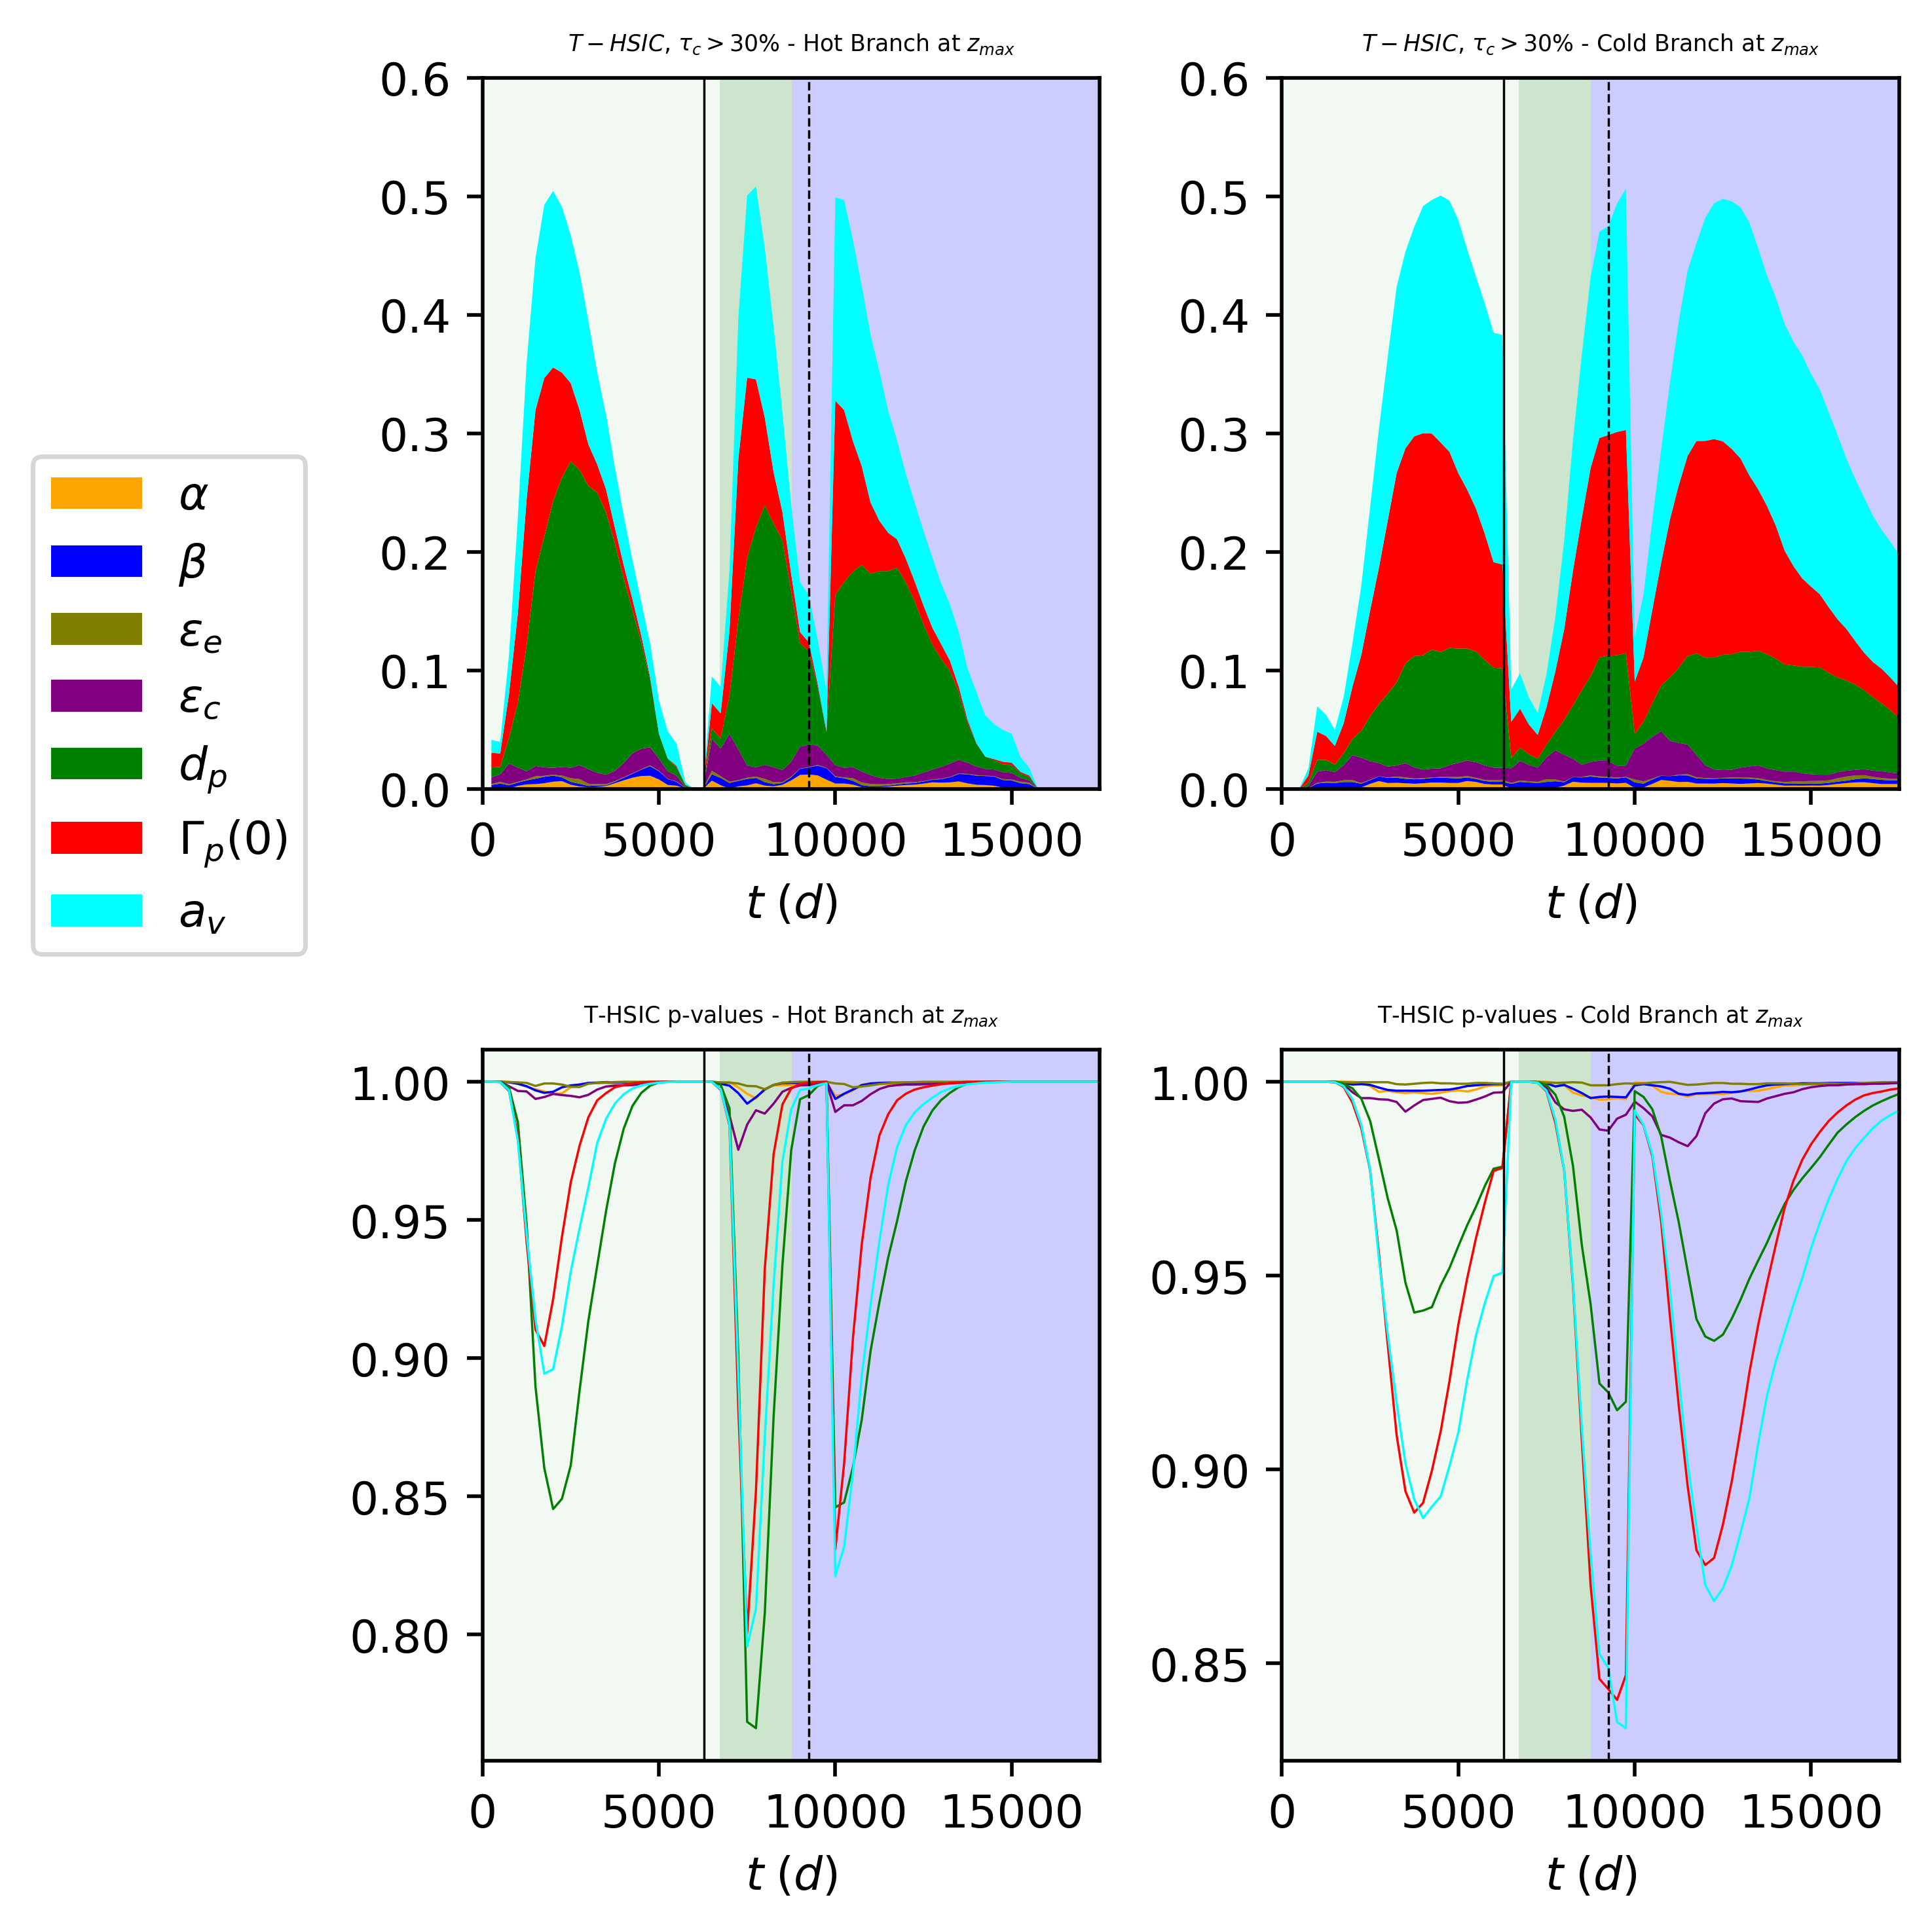

In [62]:
fig, axs = plt.subplots(2,2,figsize=(6,6),layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_ch[c['type']]
    col = typ[str(c['ph'])]
    axs[0,0].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[0,1].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[1,0].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[1,1].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])

axs[0,0].stackplot(t,hsic_target_time_HL, labels=labels, colors=colors)
axs[0,0].set_xlim(0,17500)
axs[0,0].set_ylim(0,0.6)
axs[0,0].set_xlabel(r'$t\;(d)$')
axs[0,0].set_title(r'$T-HSIC$, $\tau_c > 30\%$ - Hot Branch at $z_{max}$', fontsize=5)

axs[0,1].stackplot(t,hsic_target_time_CL, labels=labels, colors=colors)
axs[0,1].set_xlim(0,17500)
axs[0,1].set_ylim(0,0.6)
axs[0,1].set_xlabel(r'$t\;(d)$')
axs[0,1].set_title(r'$T-HSIC$, $\tau_c > 30\%$ - Cold Branch at $z_{max}$',  fontsize=5)

for k in range(7):
    axs[1,0].plot(t,p_values_target_HL[k], c=colors[k], linewidth=0.5)
    axs[1,0].set_xlim(0,17500)
    #axs[1,0].set_ylim(0,1.15)
    axs[1,0].set_xlabel(r'$t\;(d)$')
    axs[1,0].set_title(r'T-HSIC p-values - Hot Branch at $z_{max}$',  fontsize=5)

    axs[1,1].plot(t,p_values_target_CL[k], c=colors[k], linewidth=0.5)
    axs[1,1].set_xlim(0,17500)
    #axs[1,1].set_ylim(0,1.15)
    axs[1,1].set_xlabel(r'$t\;(d)$')
    axs[1,1].set_title(r'T-HSIC p-values - Cold Branch at $z_{max}$',  fontsize=5)

axs[0,0].legend(bbox_to_anchor=(-0.25,0.5))


nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs[0,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[0,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventif':
        axs[0,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[0,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)

fig.savefig('plots/HSIC/t_HSIC.pdf', format='pdf')
fig.savefig('plots/HSIC/t_HSIC.png', format='png')

# Conditional HSIC

In [9]:
#WORKS ONLY WITH VSTAT
hsic_cond_time_HL, hsic_cond_time_CL = [], []
p_values_cond_HL, p_values_cond_CL = [], []
estimatorType_v = ot.HSICVStat() 

In [10]:
dist = ot.DistanceToDomainFunction(ot.Interval(30, float('inf')))
func = ot.SymbolicFunction('x', 'exp(-0.5 * x)')
weight = ot.ComposedFunction(func, dist)

In [11]:
for i in range(75):

    tauSample_HL = outputSample_HL[:,i]
    tauSample_CL = outputSample_CL[:,i]
        
    covarianceModelCollection_HL, covarianceModelCollection_CL = [], []
    
    for i in range(7):
        Xi = inputSample.getMarginal(i)
        Cov = ot.SquaredExponential(1)
        Cov.setScale(Xi.computeStandardDeviation())
        covarianceModelCollection_HL.append(Cov)
        covarianceModelCollection_CL.append(Cov)

    covarianceModelCollection_HL.append(ot.SquaredExponential(tauSample_HL.computeStandardDeviation()))
    covarianceModelCollection_CL.append(ot.SquaredExponential(tauSample_CL.computeStandardDeviation()))

    hsic_v_cond_HL = ot.HSICEstimatorConditionalSensitivity(covarianceModelCollection_HL, inputSample, tauSample_HL, weight)
    hsic_v_cond_CL = ot.HSICEstimatorConditionalSensitivity(covarianceModelCollection_CL, inputSample, tauSample_CL, weight)
    
    r2_v_cond_HL = hsic_v_cond_HL.getR2HSICIndices()
    r2_v_cond_CL = hsic_v_cond_CL.getR2HSICIndices()

    hsic_cond_time_HL.append(list(np.abs(r2_v_cond_HL)))
    hsic_cond_time_CL.append(list(np.abs(r2_v_cond_CL)))
    
    #hsic_cond_time_HL.append(hsic_u_cond_HL.getHSICIndices())
    #hsic_cond_time_CL.append(hsic_u_cond_CL.getHSICIndices())

    small_p_HL, small_p_CL = [], []
    for j in range(7):
        small_p_HL.append(round(estimatorType_v.computePValue(ot.Gamma(), 969, hsic_v_cond_HL.getR2HSICIndices()[j], 0.0),4))
        small_p_CL.append(round(estimatorType_v.computePValue(ot.Gamma(), 969, hsic_v_cond_CL.getR2HSICIndices()[j], 0.0),4))

    p_values_cond_HL.append(small_p_HL)
    p_values_cond_CL.append(small_p_CL)

In [12]:
hsic_cond_time_HL = list(np.transpose(np.asarray(hsic_cond_time_HL)))
hsic_cond_time_CL = list(np.transpose(np.asarray(hsic_cond_time_CL)))
p_values_cond_HL = list(np.transpose(np.asarray(p_values_cond_HL)))
p_values_cond_CL = list(np.transpose(np.asarray(p_values_cond_CL)))

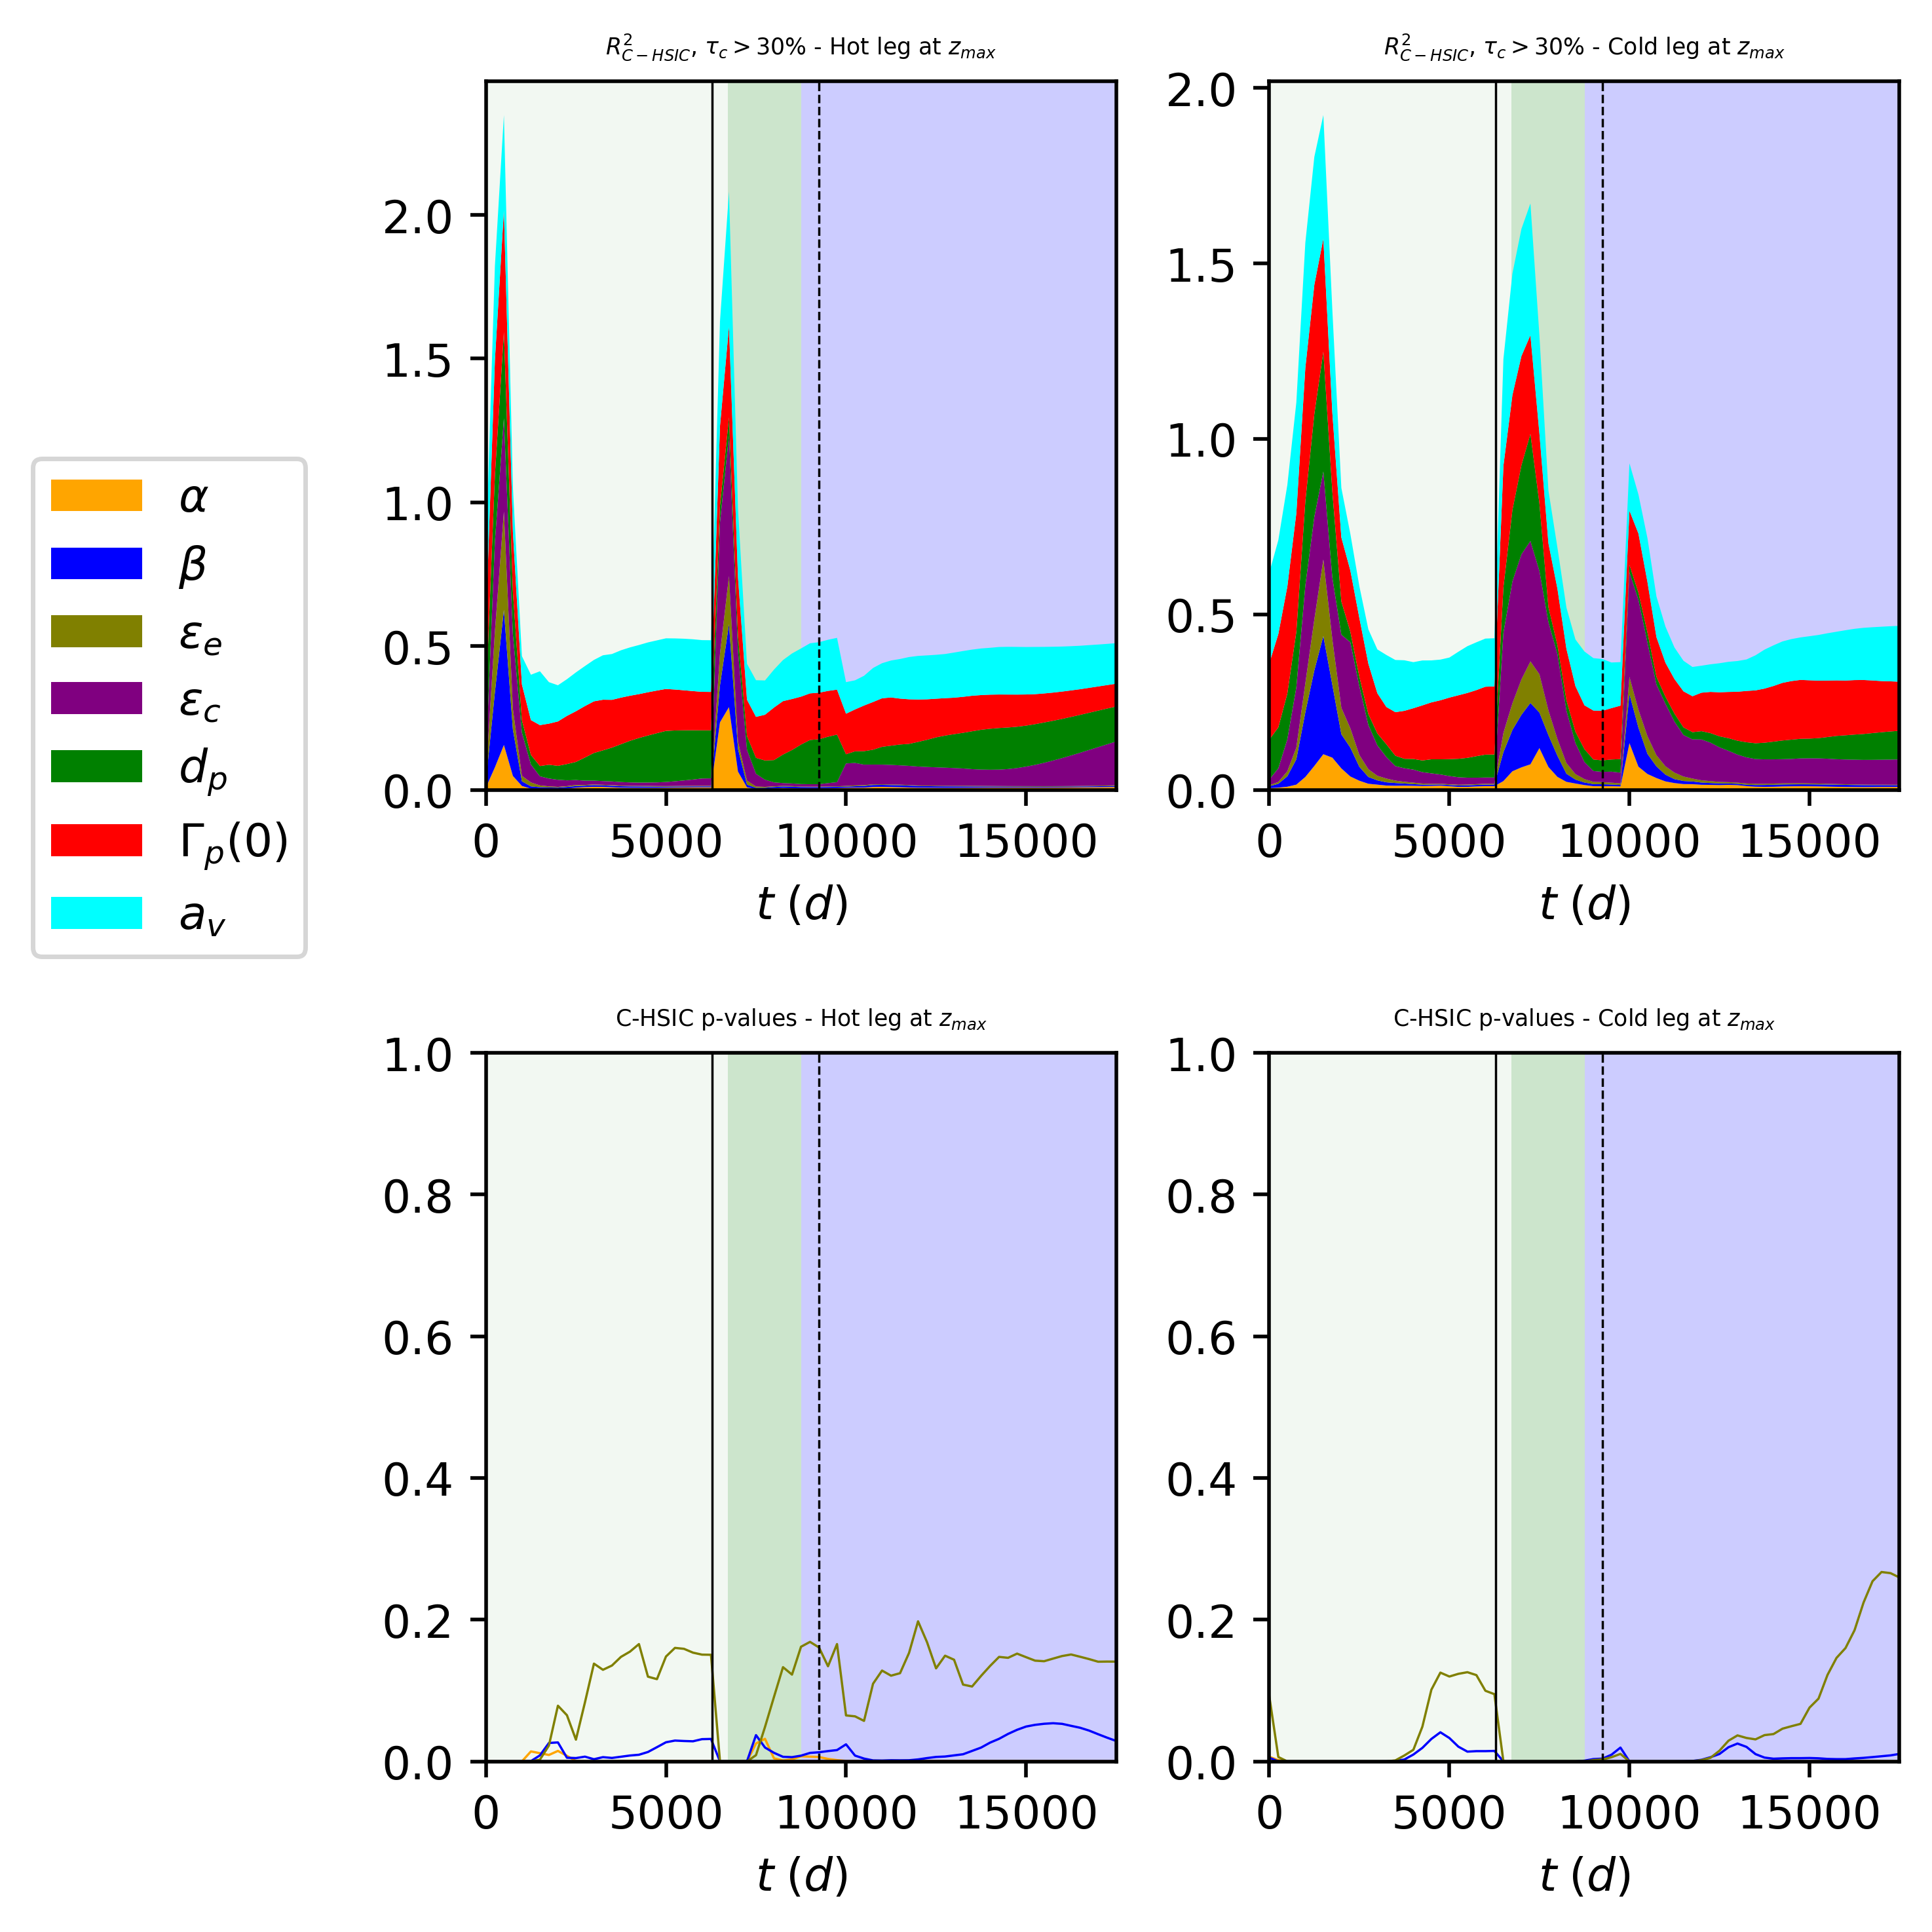

In [14]:
fig, axs = plt.subplots(2,2,figsize=(6,6),layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_900['CHL4GV2']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_ch[c['type']]
    col = typ[str(c['ph'])]
    axs[0,0].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[0,1].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[1,0].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[1,1].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])

axs[0,0].stackplot(t,hsic_cond_time_HL, labels=labels, colors=colors)
axs[0,0].set_xlim(0,17500)
#axs[0,0].set_ylim(0,0.6)
axs[0,0].set_xlabel(r'$t\;(d)$')
axs[0,0].set_title(r'$R^{2}_{C-HSIC}$, $\tau_c > 30\%$ - Hot leg at $z_{max}$', fontsize=5)

axs[0,1].stackplot(t,hsic_cond_time_CL, labels=labels, colors=colors)
axs[0,1].set_xlim(0,17500)
#axs[0,1].set_ylim(0,0.6)
axs[0,1].set_xlabel(r'$t\;(d)$')
axs[0,1].set_title(r'$R^{2}_{C-HSIC}$, $\tau_c > 30\%$ - Cold leg at $z_{max}$',  fontsize=5)

for k in range(7):
    axs[1,0].plot(t,p_values_cond_HL[k], c=colors[k], linewidth=0.5)
    axs[1,0].set_xlim(0,17500)
    axs[1,0].set_ylim(0,1.0)
    axs[1,0].set_xlabel(r'$t\;(d)$')
    axs[1,0].set_title(r'C-HSIC p-values - Hot leg at $z_{max}$',  fontsize=5)

    axs[1,1].plot(t,p_values_cond_CL[k], c=colors[k], linewidth=0.5)
    axs[1,1].set_xlim(0,17500)
    axs[1,1].set_ylim(0,1.0)
    axs[1,1].set_xlabel(r'$t\;(d)$')
    axs[1,1].set_title(r'C-HSIC p-values - Cold leg at $z_{max}$',  fontsize=5)
axs[0,0].legend(bbox_to_anchor=(-0.25,0.5))


nett = input_900['CHL4GV2']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs[0,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[0,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventif':
        axs[0,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[0,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)

fig.savefig('HSIC_cond_tot.pdf', format='pdf')